# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
from sklearn.metrics import brier_score_loss, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc

# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable, check_level
from utils import check_nulls, plot_hist_box, plot_bar_pie, plot_training
pd.set_option('display.max_columns', 500)

# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

# Set random seed for reproducibility
SEED=0
np.random.seed(SEED)
tf.random.set_seed(SEED)

2022-08-21 12:55:54.972872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-21 12:55:54.972897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# #OPEN ISSUE ON MAC OSX for TF model training
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
# Load the dataset in a dataframe
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
# First of all it's a good practice having a look at
# the head and the tail, because sometimes first and/or
# last line are a summary or are simply useless
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
# Last lines
df.tail()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
143419,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO
143420,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO
143421,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO
143422,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO
143423,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,?,?,530,530|787,0,0,0,13,9,3,3,NaN,None,None,No,NO


## Determine Level of Dataset (Line or Encounter)

In [6]:
# from utils import check_level
check_level(df, 'encounter_id', 'patient_nbr')

Number of lines: 143424
Number of encounters: 101766
Number of patients: 71518

Possible levels of the dataset:
  -Line: True
  -Encounter: False
  -Longitudinal: False


**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

**Student Response:** From the previous analysis it is deduced that the dataset is at the line level. The encounter and patient codes are sufficient to reach this conclusion.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:

- a. Field(s) with high amount of missing/zero values
- b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
- c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
- d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

### General analysis

In [7]:
# Lets see some statistics
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434240e+05,1.434240e+05,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,1.674290e+08,5.493608e+07,2.027694,3.655316,5.701096,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,1.019046e+08,3.857840e+07,1.427585,5.219279,4.064532,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630783e+07,1.000000,1.000000,7.000000,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320897e+08,8.823627e+07,3.000000,3.000000,7.000000,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


In [8]:
# The ones seen above are the numeric features
numeric_features = list(df.describe())
print(numeric_features)

['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']


In [9]:
# The rest of features are non-numeric
non_numeric_features = list(df[df.columns.difference(numeric_features)])
print(non_numeric_features)

['A1Cresult', 'age', 'change', 'gender', 'max_glu_serum', 'medical_specialty', 'ndc_code', 'other_diagnosis_codes', 'payer_code', 'primary_diagnosis_code', 'race', 'readmitted', 'weight']


In [10]:
# Let's see the exact data type of each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

In [11]:
# In this case, all numeric features are of type int64, while
# non-numeric features are of type object
types_dict = dict(df.columns.to_series().groupby(df.dtypes).groups)
for k in types_dict.keys():
    print('Type: {}\nFeatures: {}\n'.format(k, list(types_dict[k])))

Type: int64
Features: ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']

Type: object
Features: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code', 'max_glu_serum', 'A1Cresult', 'change', 'readmitted']



See that are some features that could seem strange that haven't a numeric type, such as weight and age. Age is treated as a range, so it's non-numerical. On the other hand, weight is numerical, but there's an issue with this feature that we'll see in a minute.

### Missing values

In [12]:
# Let's use the user defined function to identify missing values

# from utils import check_nulls
null_df = check_nulls(df)

In [13]:
null_df

,column,#_null,%_null,#_none,%_none,#_ques,%_ques,#_zero,%_zero
encounter_id,encounter_id,0,0.00000,0,0.000000,0,0.000000,0,0.000000
patient_nbr,patient_nbr,0,0.00000,0,0.000000,0,0.000000,0,0.000000
race,race,0,0.00000,0,0.000000,3309,2.307145,0,0.000000
gender,gender,0,0.00000,0,0.000000,0,0.000000,0,0.000000
age,age,0,0.00000,0,0.000000,0,0.000000,0,0.000000
weight,weight,0,0.00000,0,0.000000,139122,97.000502,0,0.000000
admission_type_id,admission_type_id,0,0.00000,0,0.000000,0,0.000000,0,0.000000
discharge_disposition_id,discharge_disposition_id,0,0.00000,0,0.000000,0,0.000000,0,0.000000
admission_source_id,admission_source_id,0,0.00000,0,0.000000,0,0.000000,0,0.000000
time_in_hospital,time_in_hospital,0,0.00000,0,0.000000,0,0.000000,0,0.000000


In the dataframe before we can see the different types of null values and its percentage. Take into account that, depending on the feature, a zero value can be a valid value. In our case we have zeroes only in features in which this value is acceptable, so we don't have to modify anything in this sense.

On the other hand, we can see that there's a lot of values marked as "?", meaning that the real value is not known. It's important to note that more than 97% of the weights (per line) are not known; this is equivalent to a 94% of the patients (in case that all the weights were from different patient), so this feature shouldn't be used in our prediction.

### Distribution of numeric features

We have some variables that, although they are numerical, it is not worth calculating the distribution, since it lacks physical meaning. Such is the case, for example, of all those numerical codes that act as identifiers ('encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id')

On the other hand, we can check the distributions of other numerical variables.

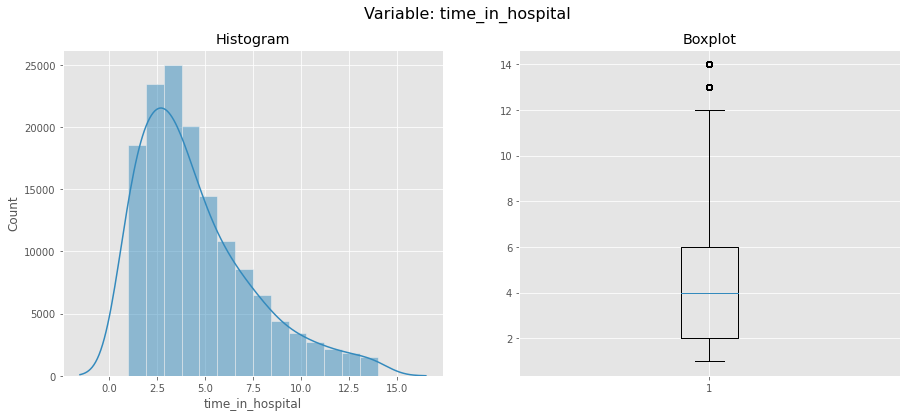

In [14]:
# Variable 'time_in_hospital'
v = 'time_in_hospital'
plot_hist_box(df[v],
              name=v,
              bins=len(np.unique(df[v])),
              kde=True,
              kde_kws={"cut": 3, "bw_adjust": 3})

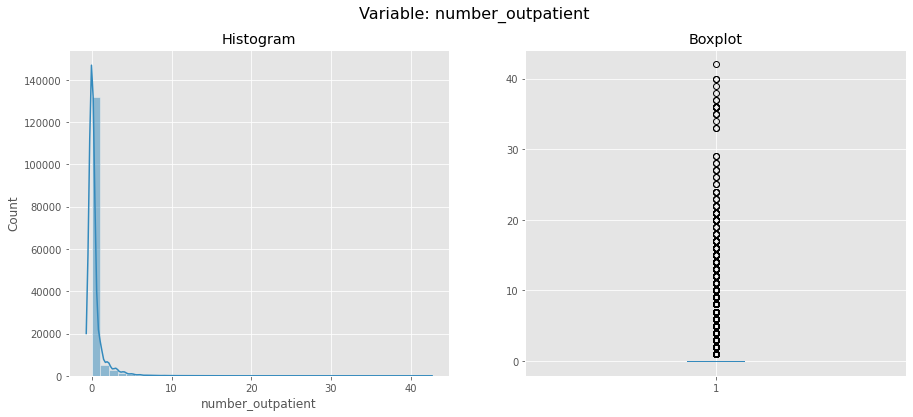

In [15]:
# Variable 'number_outpatient'
v = 'number_outpatient'
plot_hist_box(df[v],
              name=v,
              bins=len(np.unique(df[v])),
              kde=True,
              kde_kws={"cut": 2, "bw_adjust": 3})

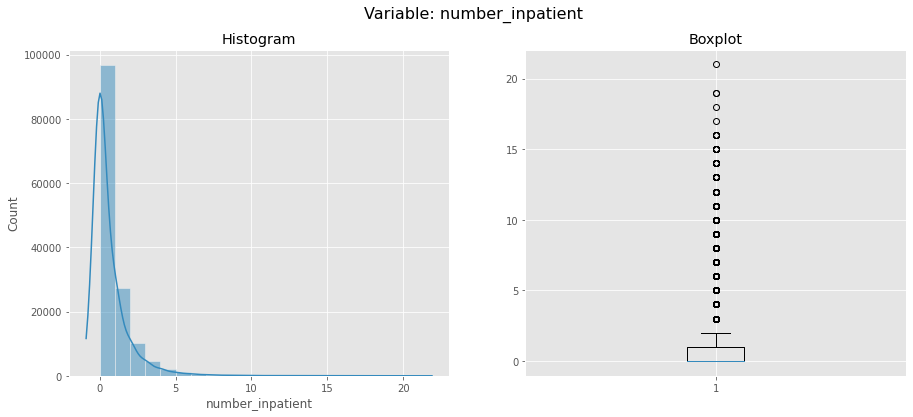

In [16]:
# Variable 'number_inpatient'
v = 'number_inpatient'
plot_hist_box(df[v],
              name=v,
              bins=len(np.unique(df[v])),
              kde=True,
              kde_kws={"cut": 2, "bw_adjust": 4})

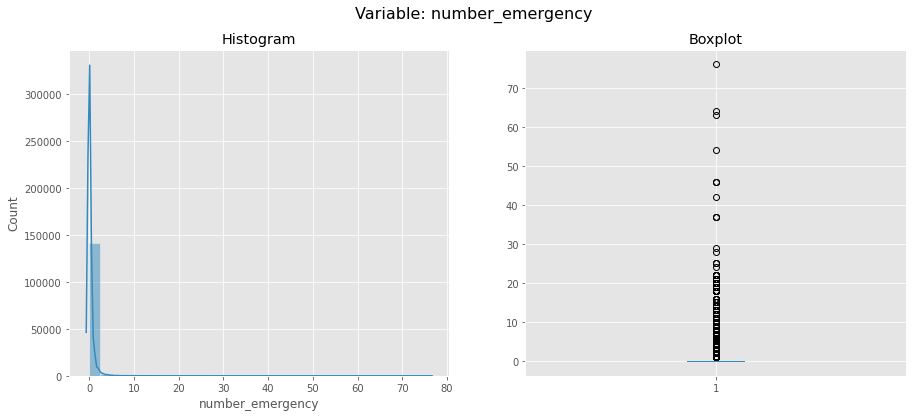

In [17]:
# Variable 'number_emergency'
v = 'number_emergency'
plot_hist_box(df[v],
             name=v,
              bins=len(np.unique(df[v])),
              kde=True,
              kde_kws={"cut": 2, "bw_adjust": 4})

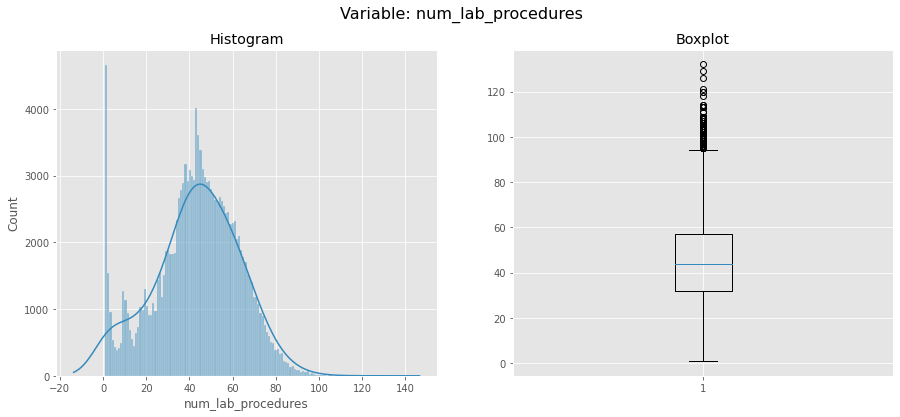

In [18]:
# Variable 'num_lab_procedures'
v = 'num_lab_procedures'
plot_hist_box(df[v],
              name=v,
              bins=len(np.unique(df[v]))+14,
              kde=True,
              kde_kws={"cut": 2, "bw_adjust": 4})

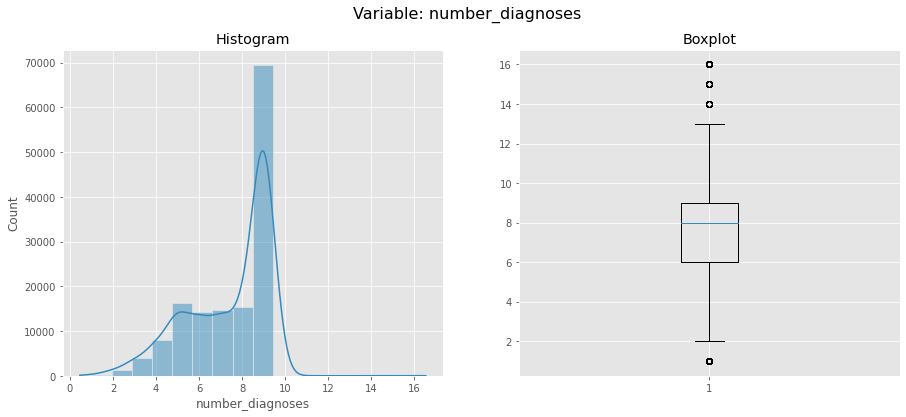

In [19]:
v = 'number_diagnoses'
plot_hist_box(df[v],
              name=v,
              bins=len(np.unique(df[v])),
              kde=True,
              kde_kws={"cut": 1, "bw_adjust": 3})

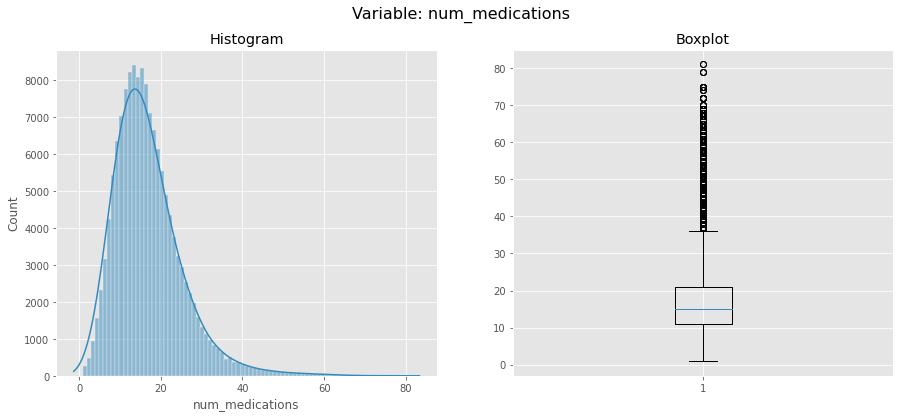

In [20]:
v = 'num_medications'
plot_hist_box(df[v],
              name=v,
              bins=len(np.unique(df[v]))+6,
              kde=True,
              kde_kws={"cut": 1, "bw_adjust": 3})

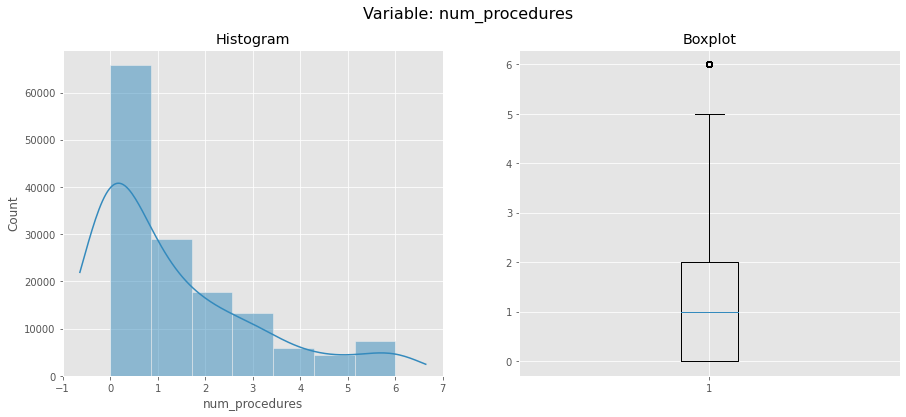

In [21]:
v = 'num_procedures'
plot_hist_box(df[v],
              name=v,
              bins=len(np.unique(df[v])),
              kde=True,
              kde_kws={"cut": 1, "bw_adjust": 4})

None of the variables seen above have a normal distribution.

Let's check the 'age' variable. Although strictly speaking it is not a numeric variable (we have it as a bucketized feature), we can check for its normality and see that the distribution is not normal.

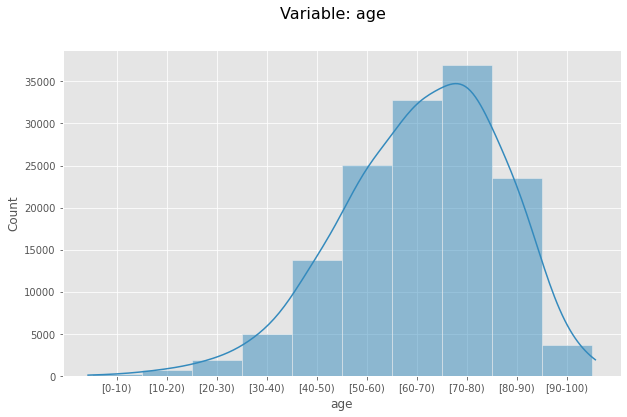

In [22]:
v = 'age'
plt.figure(figsize=(10, 6))
sns.histplot(df[v], kde=True, kde_kws={"cut": 1, "bw_adjust": 4});
plt.suptitle('Variable: {}'.format(v), fontsize=16);

Finally, see that other variables that are numerical in principle, such as weight, cannot be considered due to the large number of null values.

### Cardinality

In [23]:
card = pd.DataFrame({'Cardinality': df[non_numeric_features].nunique()})
card.sort_values(by='Cardinality', ascending=False)

,Cardinality
other_diagnosis_codes,19374
primary_diagnosis_code,717
ndc_code,251
medical_specialty,73
payer_code,18
age,10
weight,10
race,6
A1Cresult,4
max_glu_serum,4


The features with high cardinality are:

 * other_diagnosis_codes
 * primary_diagnosis_code
 * ndc_code
 * medical_specialty

Unique values: ['Female', 'Male', 'Unknown/Invalid']


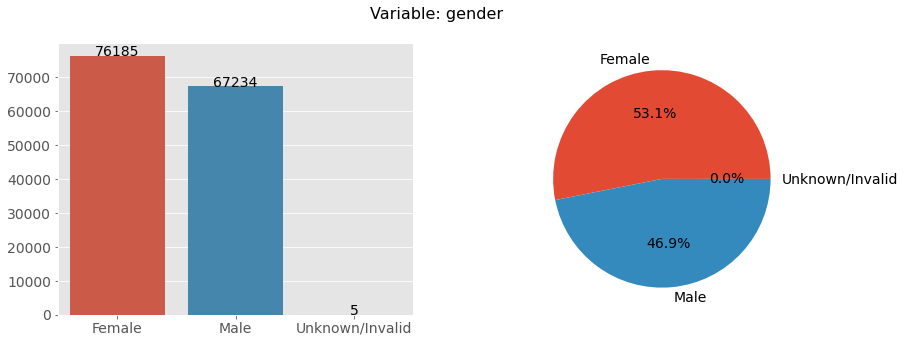

In [24]:
# Let's check some unique values in the different features
v = 'gender'
print('Unique values: {}'.format(list(df[v].unique())))

# Check for distribution
plot_bar_pie(df, v)

# We have just 5 unknown values

Unique values: ['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic']


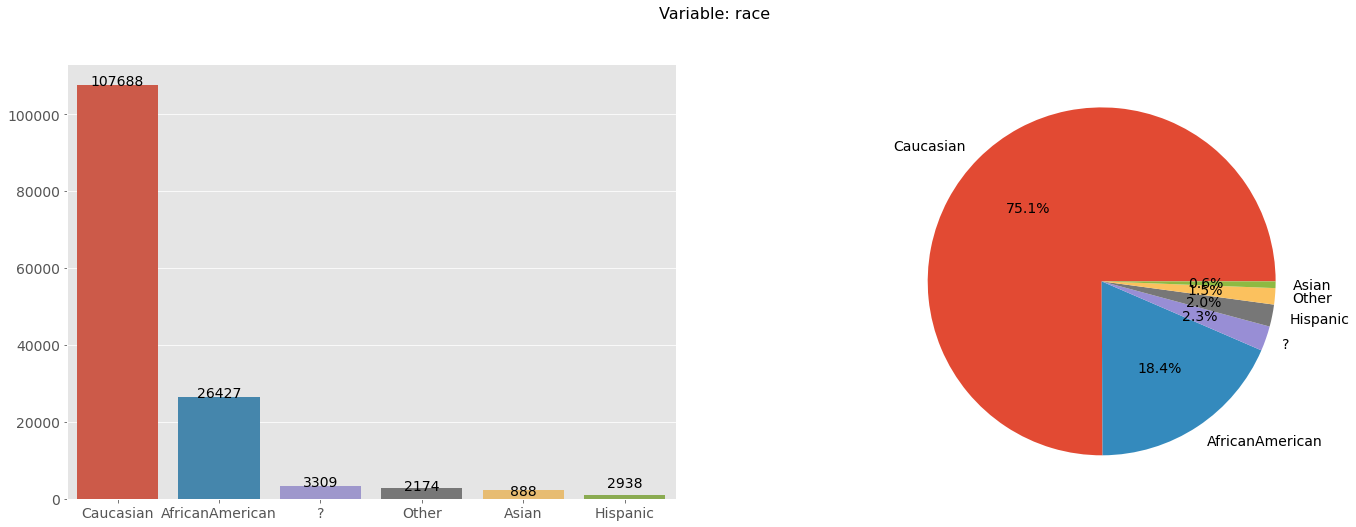

In [25]:
# Let's check some unique values in the different features
v = 'race'
print('Unique values: {}'.format(list(df[v].unique())))

# Check for distribution
plot_bar_pie(df, v, (24, 8))

Unique values: ['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)', '[125-150)', '[175-200)', '[150-175)', '>200']


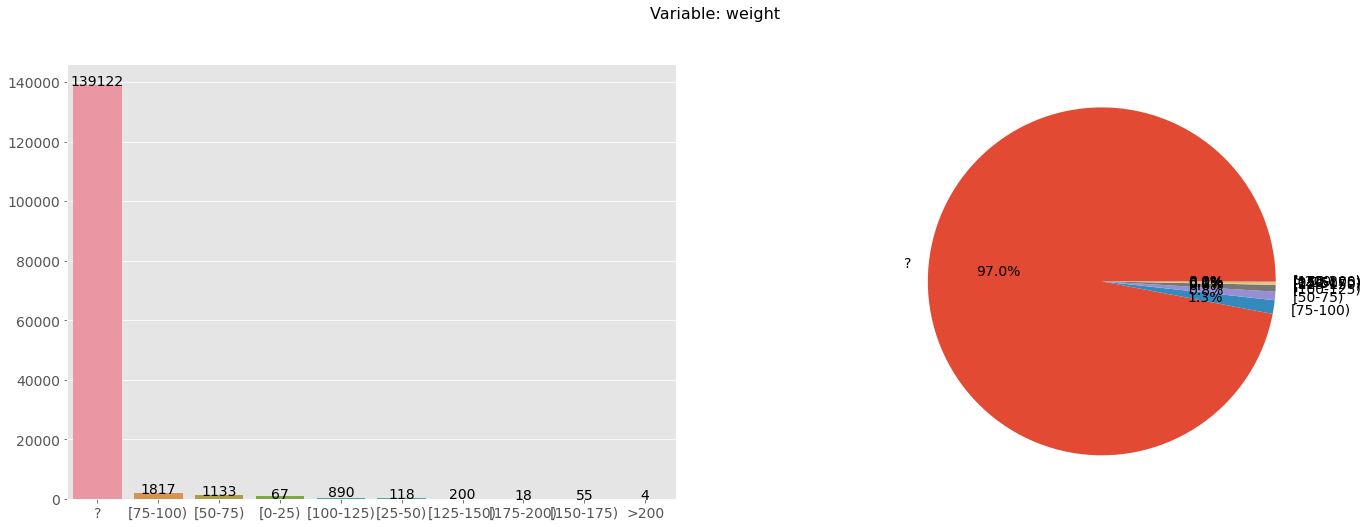

In [26]:
# Let's check some unique values in the different features
v = 'weight'
print('Unique values: {}'.format(list(df[v].unique())))

# Check for distribution
plot_bar_pie(df, v, (24, 8))

# As we already knew, there's a lot of missing values here, marked as '?'
# 97% of possible weight measures are missing

Unique values: ['?', 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM', 'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR']


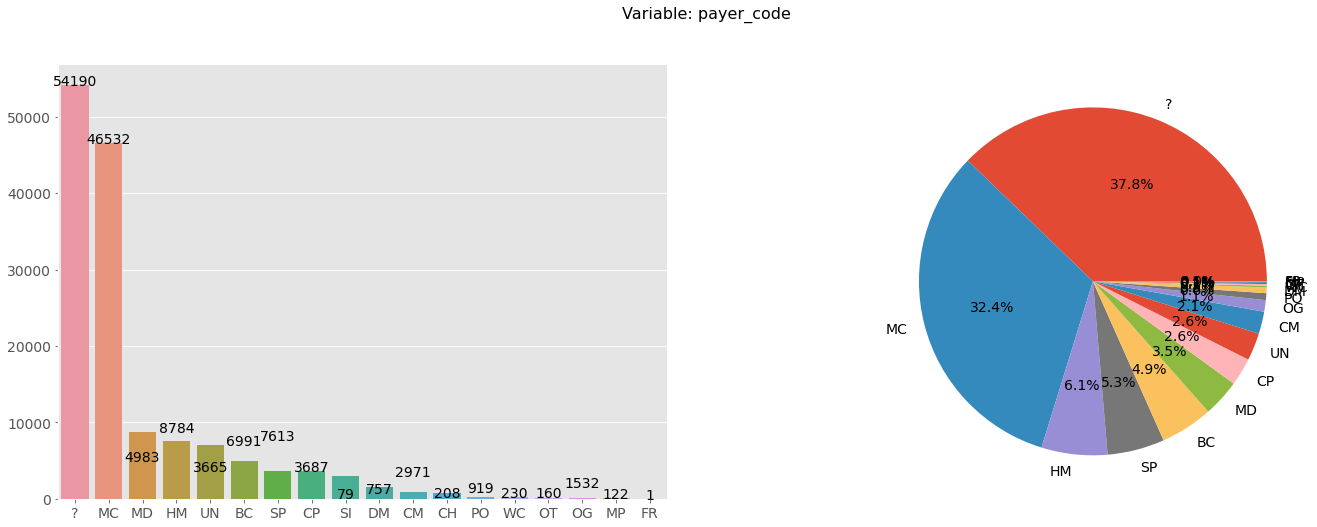

In [27]:
# Let's check some unique values in the different features
v = 'payer_code'
print('Unique values: {}'.format(list(df[v].unique())))

# Check for distribution
plot_bar_pie(df, v, (24, 8))

# The most frequent value is precisely the unknown value.
# Furthermore, it does not seem that this characteristic is going
# to be relevant in the prediction of diabetes.

Unique values: ['None', '>7', '>8', 'Norm']


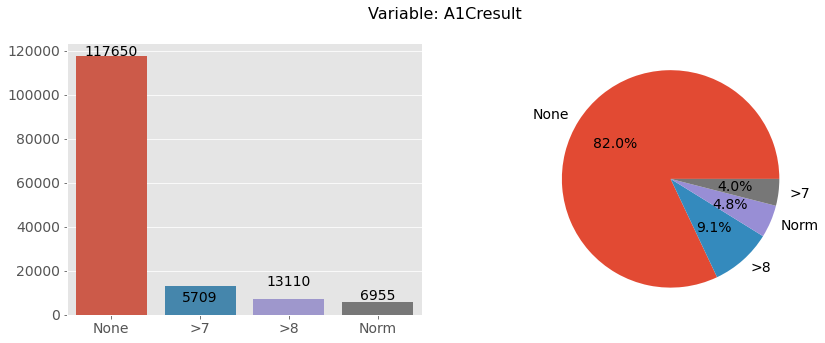

In [28]:
# Let's check some unique values in the different features
v = 'A1Cresult'
print('Unique values: {}'.format(list(df[v].unique())))

# Check for distribution
plot_bar_pie(df, v)

# 82% of results are None, meaning "not measured"

Unique values: ['None', '>300', 'Norm', '>200']


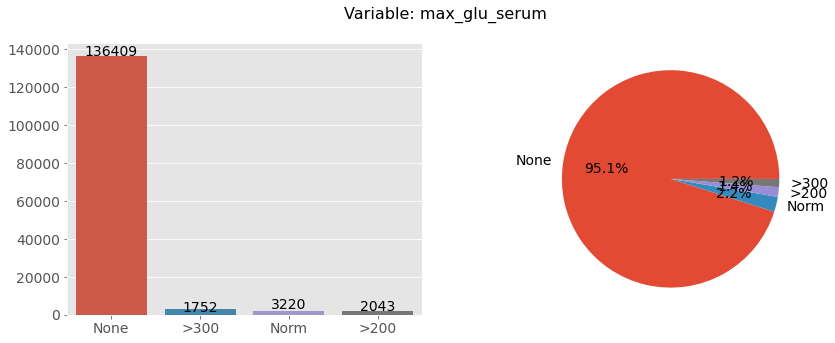

In [29]:
# Let's check some unique values in the different features
v = 'max_glu_serum'
print('Unique values: {}'.format(list(df[v].unique())))

# Check for distribution
plot_bar_pie(df, v)

# Again, the most frequent value is 'None'

Unique values: ['NO', '>30', '<30']


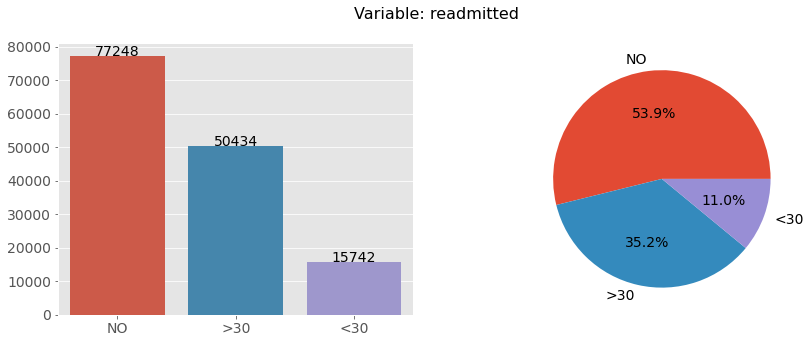

In [30]:
# Let's check some unique values in the different features
v = 'readmitted'
print('Unique values: {}'.format(list(df[v].unique())))

# Check for distribution
plot_bar_pie(df, v)

Unique values: ['No', 'Ch']


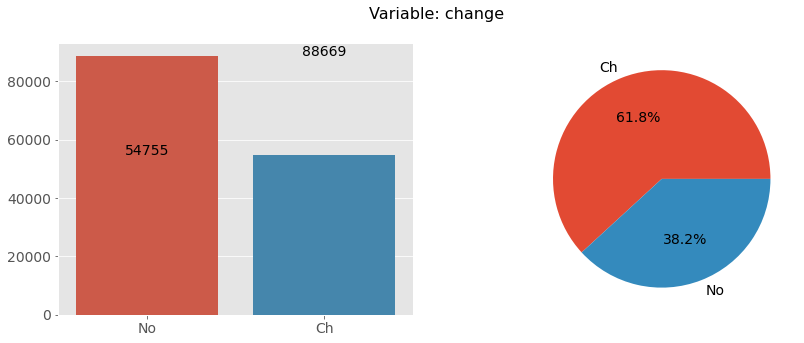

In [31]:
# Let's check some unique values in the different features
v = 'change'
print('Unique values: {}'.format(list(df[v].unique())))

# Check for distribution
plot_bar_pie(df, v)

Unique values: ['Pediatrics-Endocrinology', '?', 'InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Gastroenterology', 'Surgery-Cardiovascular/Thoracic', 'Nephrology', 'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma', 'Pulmonology', 'Surgery-Neuro', 'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology', 'Pediatrics', 'Hematology/Oncology', 'Otolaryngology', 'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology', 'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology', 'Neurology', 'Anesthesiology-Pediatric', 'Radiology', 'Pediatrics-Hematology-Oncology', 'Psychology', 'Podiatry', 'Gynecology', 'Oncology', 'Pediatrics-Neurology', 'Surgery-Plastic', 'Surgery-Thoracic', 'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology', 'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine', 'PhysicalMedicineandRehabilitation', 'InfectiousDiseases', 'Anesthesiology', 'Rheumatology', 'AllergyandImmunology', 'Surgery

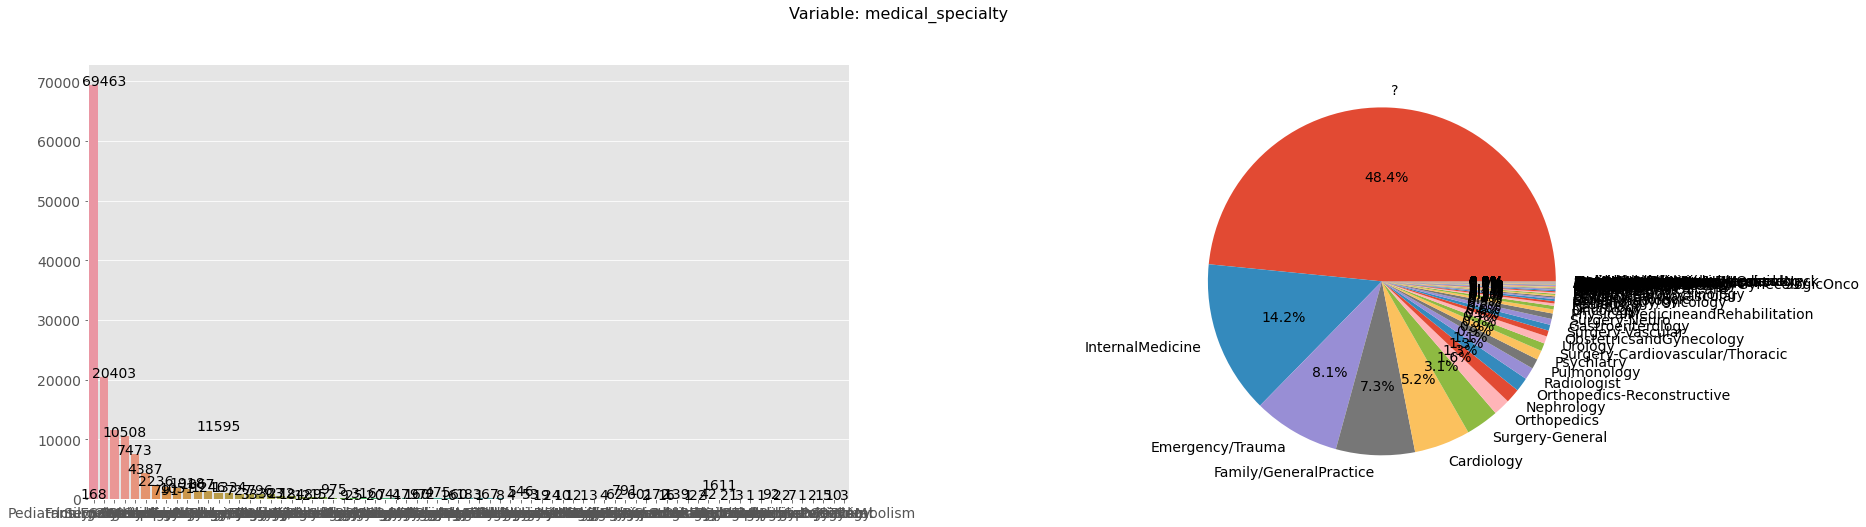

In [32]:
# Let's check some unique values in the different features
v = 'medical_specialty'
print('Unique values: {}'.format(list(df[v].unique())))

# Check for distribution
plot_bar_pie(df, v, (30, 8))

# This is a high-cardinality feature. Most of the data are missing

In [33]:
# ######NOTE: The visualization will only display in Chrome browser. ########
# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
# tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [34]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [35]:
# Let's see ndc_code dataframe
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [36]:
# And compare to our original dataframe
df.iloc[:, -5:].head()

,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,NaN,None,None,No,NO
1,68071-1701,None,None,Ch,>30
2,0378-1110,None,None,No,NO
3,68071-1701,None,None,Ch,NO
4,0049-4110,None,None,Ch,NO


'NDC_Code' in `ndc_code_df` is conceptually the same as 'ndc_code' in `df`, so we can merge both datasets. On the other hand, the feature 'Non-propietary Name' in `ndc_code_df` is much less specific, which implies that relying on it instead of the NDC code can achieve dimensionality reduction.

In [37]:
from student_utils import reduce_dimension_ndc

In [38]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [39]:
# Check that we have the column of generic_drug_name at the end
reduce_dim_df.iloc[:, -4:].head()

,A1Cresult,change,readmitted,generic_drug_name
0,None,No,NO,NaN
1,None,Ch,>30,Human Insulin
2,None,No,NO,Glipizide
3,None,Ch,NO,Human Insulin
4,None,Ch,NO,Glipizide


In [40]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [41]:
# Number of unique codes
reduce_dim_df['generic_drug_name'].nunique()

22

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [42]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [43]:
first_encounter_df = select_first_encounter(reduce_dim_df)

first_encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
12,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,Insulin Human
14,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide
15,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Human Insulin
6,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,Insulin Human


In [44]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [45]:
exclusion_list = ['generic_drug_name', 'ndc_code']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

In [46]:
print('Unique values in encounter_id: {}'.format(agg_drug_df['encounter_id'].nunique()))
print('Unique values in patient_nbr: {}'.format(agg_drug_df['patient_nbr'].nunique()))
print('Number of lines in dataframe agg_drug_df: {}'.format(len(agg_drug_df)))
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

Unique values in encounter_id: 71518
Unique values in patient_nbr: 71518
Number of lines in dataframe agg_drug_df: 71518


In [47]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,[Glipizide],0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,None,None,No,>30,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response:

* Weight: Weight shouldn't be included in the data. As seen before, there's more than 94% of missing data, so this feature is useless in this case.
* Payer_code: Regardless of the distribution of the data, it is obvious that the payer is not going to have any effect on whether one diagnosis or another is found, so this characteristic should also be excluded from the prediction.

A high-cardinality feature is not the best choice for making predictions that are trying to generalize, unless a clear mapping can indeed be found between the high-cardinality feature and the prediction.
From this point of view, the 'primary_diagnosis_code' and 'other_diagnosis_codes' shouldn't be used, since apparently it will not be possible to generalize anything from them; however, considering the fact that both 'primary_diagnosis_code' and 'other_diagnosis_codes' can be very relevant factors in the prediction due to their nature (although not due to their distribution), and the first one has much lower cardinality than the sencond one, 'primary_diagnosis_code' will be included in the dataset.


Number of unique values: 697


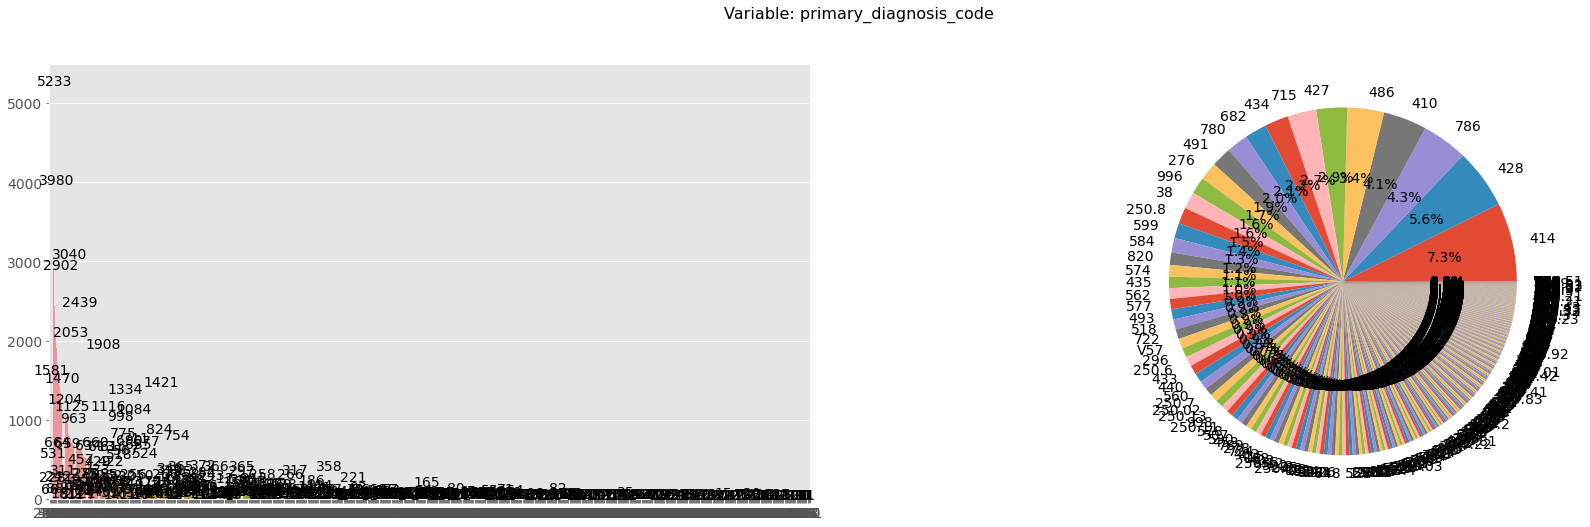

In [48]:
# In addition to the plots seen above, let's have a look at the highest-cardinality
# features
v = 'primary_diagnosis_code'
print('Number of unique values: {}'.format(len(agg_drug_df[v].unique())))

# Check for distribution
plot_bar_pie(agg_drug_df, v, (30, 8))

Number of unique values: 15756


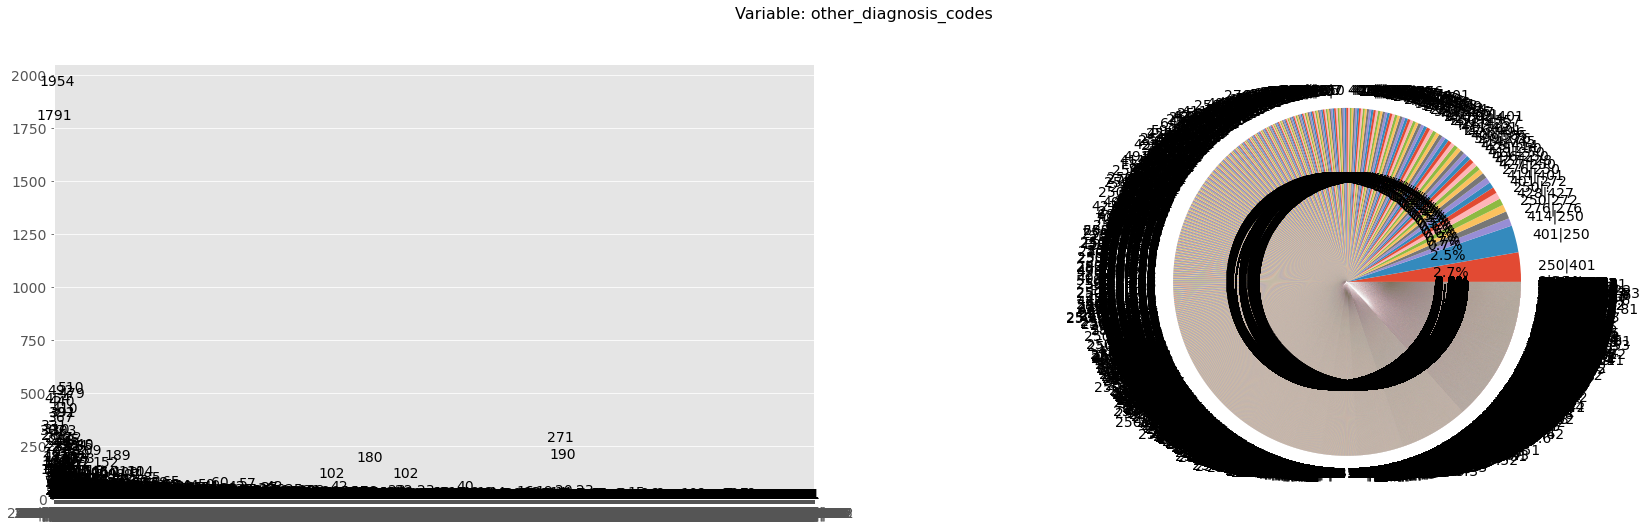

In [49]:
v = 'other_diagnosis_codes'
print('Number of unique values: {}'.format(len(agg_drug_df[v].unique())))

# Check for distribution
plot_bar_pie(agg_drug_df, v, (30, 8))

In [50]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

Below is a summary of the considerations for each variable.

 * 'encounter_id' - Not included. It's just an ID. It doesn't have any predictor capacity.

 * 'patient_nbr' - Not included. It's an ID.
 
 * 'race' - Included. It's a demographic feature.

 * 'gender' - Included. It's a demographic feature.

 * 'age' - Included. It's a demographic feature.

 * 'weight' - Not included. There's a lot of missing values.

 * 'admission_type_id' - Not included. It's an ID.

 * 'discharge_disposition_id' - Not included. It's an ID.

 * 'admission_source_id' - Not included. It's an ID.
 
 * 'time_in_hospital' - Included. This is the predictor.

 * 'payer_code' - Not included. It's just an ID and there's a lot of missing values.

 * 'medical_specialty' - Not included. Almost half of the data are unavailable.

 * 'primary_diagnosis_code' - Included. It's conceptually important.

 * 'other_diagnosis_codes' - Not included due to too high cardinality.

 * 'number_outpatient' - Not included. Very skewed distribution.

 * 'number_inpatient' - Not included. Very skewed distribution.

 * 'number_emergency' - Not included. Very skewed distribution.

 * 'num_lab_procedures' - Included. Acceptable distribution, although it's not normal.

 * 'number_diagnoses' - Included. Acceptable distribution, although it's not normal.

 * 'num_medications' - Included. Acceptable distribution, although it's not normal.

 * 'num_procedures' - Included. Acceptable distribution, although it's not normal.

 * 'ndc_code' - Not included. Used it's one-hot encoding instead.

 * 'max_glu_serum' - Not included. There's a lot of missing data.

 * 'A1Cresult - Not included. There's a lot of missing data.

 * 'change' - Not included. This variable indicates a change in medication. Conceptually irrelevant.

 * 'readmitted'- Not included. Very biased and conceptually irrelevant.

In [51]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = [ "primary_diagnosis_code"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = [ "num_lab_procedures", "number_diagnoses", "num_medications", "num_procedures"]
PREDICTOR_FIELD = 'time_in_hospital'

In [52]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]

In [53]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

I think that each feature should be studied as a separate issue. A better approach, depending on the circumstances, might be to impute to the mean or the mode. In other cases zero and NaN would be acceptable.

In [54]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/mikweeh/anaconda3/envs/nd320-c1-emr-data-starter/project/starter_code/utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/mikweeh/anaconda3/envs/nd320-c1-emr-data-starter/project/starter_code/utils.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/mikweeh/anaconda3/envs/nd320-c1-emr-data-starter/project/starter_code/utils.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [55]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [56]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [57]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


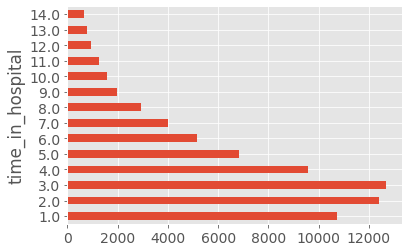

In [58]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6396
2.0     7461
3.0     7750
4.0     5743
5.0     4051
6.0     3109
7.0     2364
8.0     1744
9.0     1173
10.0     919
11.0     739
12.0     549
13.0     489
14.0     424
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


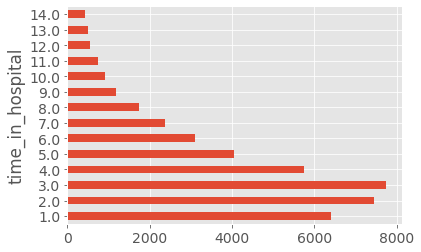

In [59]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2119
2.0     2436
3.0     2505
4.0     1949
5.0     1399
6.0     1022
7.0      803
8.0      600
9.0      410
10.0     323
11.0     249
12.0     204
13.0     164
14.0     120
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


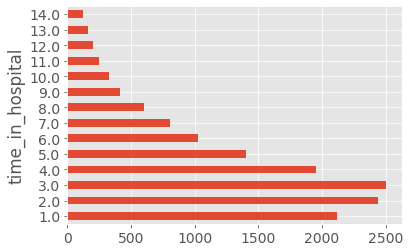

In [60]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


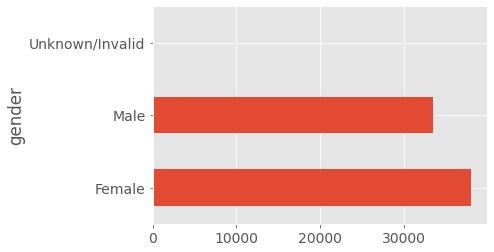

In [61]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22815
Male               20095
Unknown/Invalid        1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


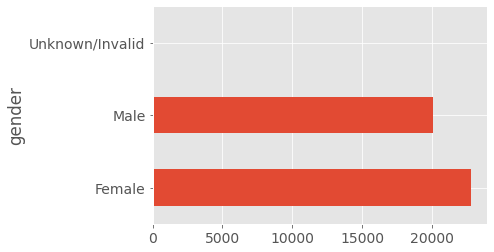

In [62]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             7555
Male               6747
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


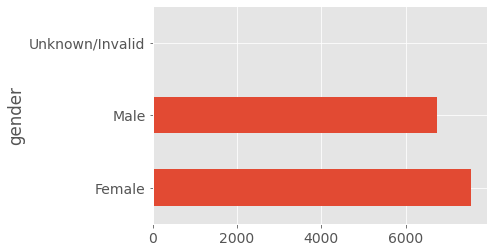

In [63]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and **for larger datasets, the 'make_csv_dataset' method is recommended** -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [64]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

2022-08-21 13:03:22.744688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 13:03:22.745327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-21 13:03:22.745397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-21 13:03:22.745457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-21 13:03:22.745514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [65]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [66]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived from the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [67]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

Feature: primary_diagnosis_code - Unique values: 648 - Embedding column
Feature: race - Unique values: 7 - One-hot column
Feature: gender - Unique values: 4 - One-hot column
Feature: age - Unique values: 11 - One-hot column
Feature: Acarbose - Unique values: 4 - One-hot column
Feature: Glimepiride - Unique values: 4 - One-hot column
Feature: Glipizide - Unique values: 4 - One-hot column
Feature: Glipizide_And_Metformin_Hcl - Unique values: 4 - One-hot column
Feature: Glipizide_And_Metformin_Hydrochloride - Unique values: 4 - One-hot column
Feature: Glyburide - Unique values: 4 - One-hot column
Feature: Glyburide_And_Metformin_Hydrochloride - Unique values: 4 - One-hot column
Feature: Glyburide-metformin_Hydrochloride - Unique values: 4 - One-hot column
Feature: Human_Insulin - Unique values: 4 - One-hot column
Feature: Insulin_Human - Unique values: 4 - One-hot column
Feature: Metformin_Hcl - Unique values: 4 - One-hot column
Feature: Metformin_Hydrochloride - Unique values: 4 - One-ho

In [68]:
# Exemple of categorical field with embedding column
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=648, num_oov_buckets=1, dtype=tf.string, default_value=-1, file_format=None), dimension=300, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7ff95d37d850>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)
tf.Tensor(
[[-0.02118386 -0.05903383 -0.02288947 ... -0.03803992  0.01392607
   0.00623681]
 [ 0.02995371 -0.0334928  -0.07004187 ... -0.0006634  -0.07120486
   0.03869072]
 [ 0.04048154 -0.01559515 -0.0649397  ... -0.00063673 -0.05732716
   0.00526006]
 ...
 [ 0.08146645  0.0449579   0.02046751 ...  0.06148739 -0.11123708
   0.05843588]
 [-0.07095733 -0.05523602 -0.04510594 ... -0.00820297 -0.08680897
  -0.04240577]
 [-0.07095733 -0.05523602 -0.04510594 ... -0.00820297 -0.086

In [69]:
# Exemple of categorical field with indicator column
test_cat_var2 = tf_cat_col_list[1]
print("Example categorical field:\n{}".format(test_cat_var2))
demo(test_cat_var2, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='race', vocabulary_file='./diabetes_vocab/race_vocab.txt', vocabulary_size=7, num_oov_buckets=1, dtype=tf.string, default_value=-1, file_format=None))
tf.Tensor(
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]], shape=(128, 8), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [70]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [71]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [72]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [73]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7ff952ecfdd0>, mean=42.99133089417632, std=19.959092851153937))

tf.Tensor(
[[-0.57894737]
 [ 0.        ]
 [ 0.31578946]
 [ 0.57894737]
 [ 1.0526316 ]
 [ 1.1052631 ]
 [ 0.05263158]
 [-0.21052632]
 [-2.0526316 ]
 [-0.42105263]
 [-2.1052632 ]
 [ 0.36842105]
 [-0.5263158 ]
 [ 1.3684211 ]
 [ 0.68421054]
 [-1.3684211 ]
 [ 0.31578946]
 [ 0.31578946]
 [ 0.6315789 ]
 [-1.3157895 ]
 [-0.10526316]
 [ 1.7368422 ]
 [-0.36842105]
 [-0.47368422]
 [ 1.2105263 ]
 [ 0.2631579 ]
 [ 1.        ]
 [ 0.2631579 ]
 [ 0.5263158 ]
 [ 1.        ]
 [-0.42105263]
 [-0.84210527]
 [ 0.7368421 ]
 [-0.7368421 ]
 [-0.57894737]
 [-0.10526316]
 [ 1.1578947 ]
 [ 0.5263158 ]
 [ 0.6315789 ]
 [-0.36842105]
 [-1.9473684 ]
 [-0.05263158]
 [ 1.6315789 ]
 [ 0.7894737 ]
 [ 2.1052632 ]
 [ 1.2105263 ]
 [ 0.42105263]
 [-0.5263158 ]
 [ 1.526315

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [74]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [75]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(lambda t:tfp.distributions.Normal(loc=t[..., :1],
            scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)

    opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0008, rho = 0.9)
    model.compile(optimizer=opt, loss=loss_metric, metrics=[loss_metric])
    #model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=5)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [76]:
n_epochs = 45
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, claim_feature_layer,  epochs=n_epochs)

Epoch 1/45
336/336 [==============================] - 7s 14ms/step - loss: 26.5900 - mse: 26.4331 - val_loss: 16.5494 - val_mse: 16.2078
Epoch 2/45
336/336 [==============================] - 4s 11ms/step - loss: 16.6612 - mse: 16.0629 - val_loss: 14.7308 - val_mse: 14.0478
Epoch 3/45
336/336 [==============================] - 4s 11ms/step - loss: 13.6816 - mse: 12.7927 - val_loss: 11.8746 - val_mse: 10.9433
Epoch 4/45
336/336 [==============================] - 4s 11ms/step - loss: 12.0800 - mse: 11.2021 - val_loss: 10.5023 - val_mse: 9.7607
Epoch 5/45
336/336 [==============================] - 4s 11ms/step - loss: 10.8533 - mse: 9.9494 - val_loss: 10.4669 - val_mse: 9.6408
Epoch 6/45
336/336 [==============================] - 4s 11ms/step - loss: 10.8686 - mse: 10.0025 - val_loss: 9.3863 - val_mse: 8.5131
Epoch 7/45
336/336 [==============================] - 4s 11ms/step - loss: 10.0188 - mse: 9.2111 - val_loss: 9.7147 - val_mse: 8.7934
Epoch 8/45
336/336 [=============================

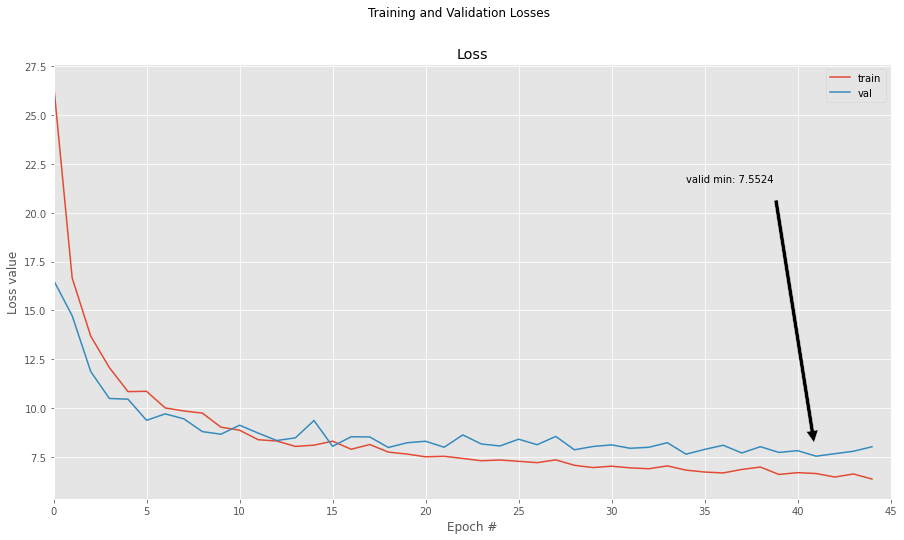

In [77]:
# Plot training curves
plot_training(len(history.history['loss']), history, patience=0)

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [78]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

1        560
2        404
3        403
4        290
        ... 
14298    513
14299    722
14300    780
14301    599
14302    682
Name: primary_diagnosis_code, Length: 14303, dtype: object, 'race': 0              Caucasian
1                  Asian
2              Caucasian
3        AfricanAmerican
4              Caucasian
              ...       
14298    AfricanAmerican
14299          Caucasian
14300          Caucasian
14301          Caucasian
14302          Caucasian
Name: race, Length: 14303, dtype: object, 'gender': 0          Male
1        Female
2          Male
3          Male
4        Female
          ...  
14298    Female
14299      Male
14300      Male
14301    Female
14302      Male
Name: gender, Length: 14303, dtype: object, 'age': 0        [40-50)
1        [70-80)
2        [60-70)
3        [40-50)
4        [80-90)
          ...   
14298    [30-40)
14299    [50-60)
14300    [60-70)
14301    [70-80)
14302    [70-80)
Name: age, Length: 14303, dtype: object, 'Acarbose': 0       

2022-08-21 13:06:33.715608: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17163600 exceeds 10% of free system memory.
2022-08-21 13:06:33.719364: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17163600 exceeds 10% of free system memory.
2022-08-21 13:06:33.721649: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17163600 exceeds 10% of free system memory.
2022-08-21 13:06:33.730356: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24543948 exceeds 10% of free system memory.


112/112 [==============================] - 2s 7ms/step


In [79]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [80]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [81]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,5.787850,3.0,2.588771,0.691145
1,3.939681,8.0,2.213480,0.691587
2,4.251644,9.0,7.920725,0.696269
3,5.721970,1.0,3.108049,0.692315
4,15.512598,8.0,7.674242,0.695150


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [82]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [83]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [84]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']]

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,86650047,Male,Caucasian,3.0,0,0
1,75046833,Female,Asian,8.0,0,1
2,56638296,Male,Caucasian,9.0,1,1
3,57838095,Male,AfricanAmerican,1.0,0,0
4,18259137,Female,Caucasian,8.0,1,1
...,...,...,...,...,...,...
14298,17113644,Female,AfricanAmerican,8.0,0,1
14299,99051696,Male,Caucasian,1.0,0,0
14300,40956858,Male,Caucasian,3.0,0,0
14301,95750973,Female,Caucasian,2.0,0,0


In [85]:
# Check proportion of positive over proportion of negatives predictions
len(pred_test_df[pred_test_df['score']==1]) / len(pred_test_df[pred_test_df['score']==0])

0.3204394387001477

In [86]:
# Check for unique value predictions
pred_test_df['score'].unique()

array([0, 1])

## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [87]:
# Report from sklearn
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      9009
           1       0.75      0.49      0.59      5294

    accuracy                           0.75     14303
   macro avg       0.75      0.70      0.71     14303
weighted avg       0.75      0.75      0.74     14303



In [88]:
# F1 score
f1_score(y_true=pred_test_df['label_value'],
         y_pred=pred_test_df['score'],
         average='weighted')

0.7370217321221404

In [89]:
# AUC 
auc = roc_auc_score(pred_test_df['label_value'], pred_test_df['score'])
print('AUC: {}'.format(auc))

AUC: 0.6979701971201783


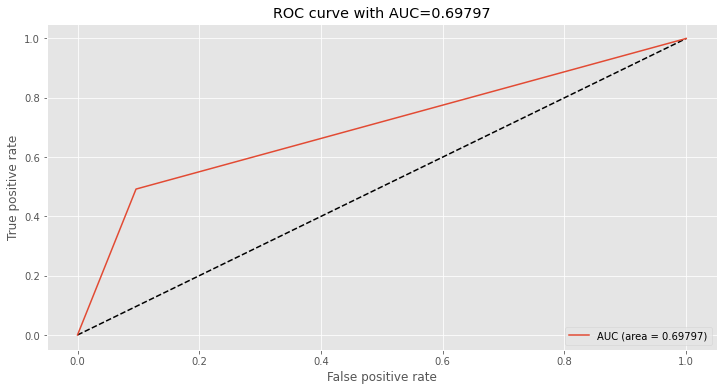

In [90]:
# Plot ROC curve
plt.style.use("ggplot")
fig, (ax1) = plt.subplots(1, 1, figsize=(12,6))
fpr, tpr, _ = roc_curve(pred_test_df['label_value'], pred_test_df['score'])

plt.figure
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC (area = {:.5f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with AUC={:.5f}'.format(auc))
plt.legend(loc='lower right')
plt.show()

__Precision-recall trade-off__

The precision indicates the degree of success of the algorithm when it predicts a positive, with respect to the total of predicted positives; that is, it answers the question: what percentage of the predicted positives are actually positive?

On the other hand, recall, also called true positive rate, is the degree of success of the algorithm seen from the real positives; that is, it answers the question: what percentage of the positives have been predicted as such by the algorithm?

Depending on the problem being studied, it may be more convenient to try to maximize one value or another. It can be done modifying the threshold. Even so, just by making use of the definitions, it can be seen that relying solely on one of these values is not recommended. For example, imagine an algorithm that always predicted positive. This algorithm would always achieve a recall of 1 (100%) and would really be useless.

The measurement of F1 takes into account precision and recall in a single datum, trying to reach a balance between both values. In this case, the F1-score obtained has been 0.678, that is a reasonable good value.

__Improvements__

There are many possibilities to fit the model. First of all, some hyperparameters could be modified to try to improve the result. For example, the learning rate, the optimizer, or even more dense layers or more units per layer could be used.

Another possibility for improvement would be to obtain more data or more features, or to train the model in different datasets.

If you have the details of what the company requires, you could also try to optimize the model for a particular metric. For example, by selecting the threshold, precision or recall could be maximized. Additionally, during training an improvement criteria metric other than validation losses could also be set (e.g. F1-score, validation precision, etc)


# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [91]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

/home/mikweeh/anaconda3/envs/udacity-ehr-env/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [92]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab,
                                        original_df=ae_df,
                                        ref_groups_dict={'race':'Caucasian', 'gender':'Male'},
                                        alpha=0.05,
                                        check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [93]:
# See some metrics
clean_xtab.iloc[:,3:-2]

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size
0,race,?,0.453237,0.906780,0.262069,0.258824,0.093220,0.546763,0.737931,0.741176,85,290,0.024489,0.226667,22,76,214,63,139,236,375
1,race,AfricanAmerican,0.491371,0.899504,0.256791,0.250774,0.100496,0.508629,0.743209,0.749226,646,1951,0.186114,0.248749,162,501,1450,484,985,1612,2597
2,race,Asian,0.346154,0.934211,0.193182,0.357143,0.065789,0.653846,0.806818,0.642857,14,88,0.004033,0.137255,5,17,71,9,26,76,102
3,race,Caucasian,0.493712,0.905554,0.248181,0.244710,0.094446,0.506288,0.751819,0.755290,2599,8111,0.748776,0.242670,636,2013,6098,1963,3976,6734,10710
4,race,Hispanic,0.436170,0.885417,0.237668,0.349206,0.114583,0.563830,0.762332,0.650794,63,223,0.018150,0.220280,22,53,170,41,94,192,286
5,race,Other,0.608108,0.880503,0.171598,0.296875,0.119497,0.391892,0.828402,0.703125,64,169,0.018438,0.274678,19,29,140,45,74,159,233
6,gender,Female,0.485891,0.898043,0.263539,0.251326,0.101957,0.514109,0.736461,0.748674,1886,5669,0.543359,0.249636,474,1494,4175,1412,2906,4649,7555
7,gender,Male,0.499581,0.910071,0.231499,0.247319,0.089929,0.500419,0.768501,0.752681,1585,5162,0.456641,0.234919,392,1195,3967,1193,2388,4359,6747
8,gender,Unknown/Invalid,-1.000000,1.000000,0.000000,-1.000000,0.000000,-1.000000,1.000000,-1.000000,0,1,0.000000,0.000000,0,0,1,0,0,1,1


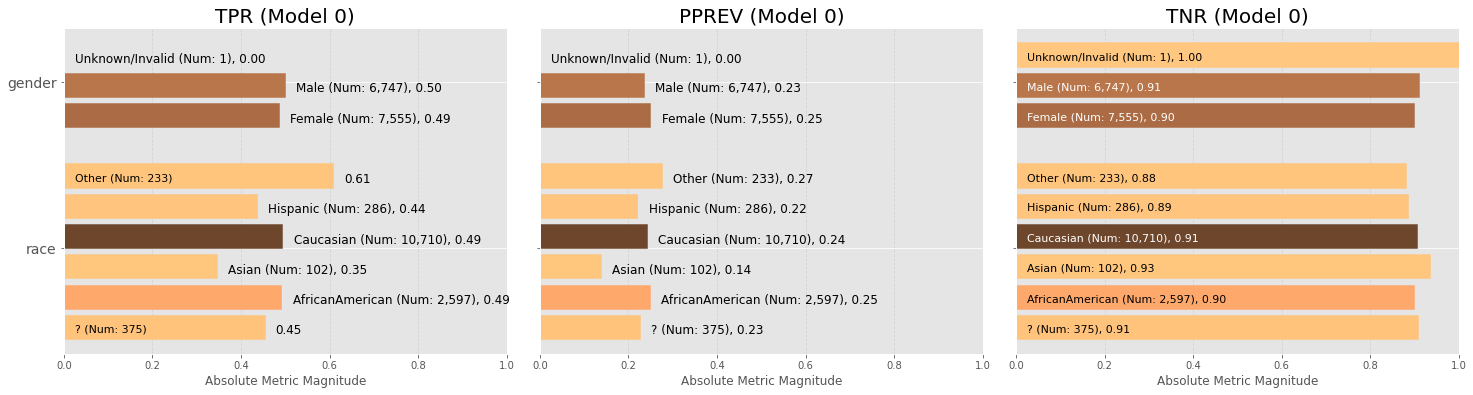

<Figure size 432x288 with 0 Axes>

In [94]:
# Plot two metrics

# True Positive Rate, Predicted Positive Prevalence and True Negative Rate 
aqp.plot_group_metric_all(xtab, metrics=['tpr', 'pprev', 'tnr'], ncols=3);

None of the three metrics used show significant bias in gender.

On the other hand, there are a significant bias in favour of Caucasian and African/American race, in TPR and PPREV. This bias should be further analyzed, because we have a lot of more data from these colectives.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

See plots below. There's not significant bias in gender, but there is a bias in race, probably due to the difference of sample size.

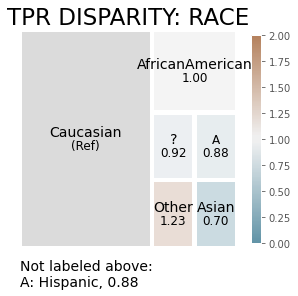

In [95]:
# Disparity in race
tpr_race_disparity = aqp.plot_disparity(bdf, group_metric='tpr_disparity', attribute_name='race')

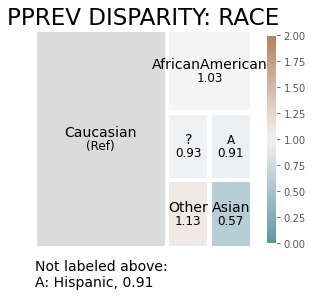

In [96]:
# Disparity in race
pprev_race_disparity = aqp.plot_disparity(bdf, group_metric='pprev_disparity', attribute_name='race')

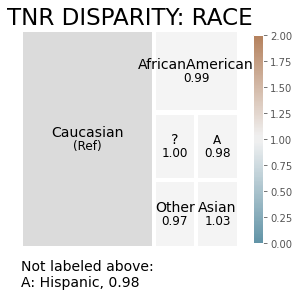

In [97]:
# Disparity in race
tnr_race_disparity = aqp.plot_disparity(bdf, group_metric='tnr_disparity', attribute_name='race')

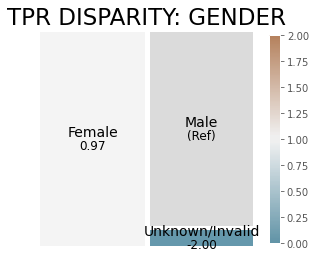

In [98]:
# Disparity in gender
tpr_gender_disparity = aqp.plot_disparity(bdf, group_metric='tpr_disparity', attribute_name='gender')

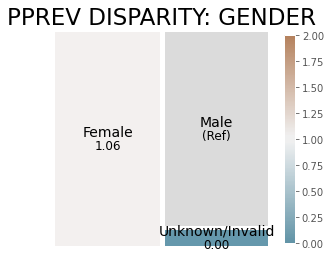

In [99]:
# Disparity in gender
pprev_gender_disparity = aqp.plot_disparity(bdf, group_metric='pprev_disparity', attribute_name='gender')

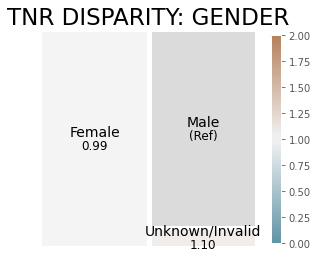

In [100]:
# Disparity in gender
tnr_gender_disparity = aqp.plot_disparity(bdf, group_metric='tnr_disparity', attribute_name='gender')